# PTEN: Analysis & Paper figures

Author:  
Matteo Cagiada | matteo.cagiada@bio.ku.dk

PTEN MAVE datasets, necessary to run the notebook, can be downloaded from:  
- Mighell, et al, 2018 (https://doi.org/10.1016/j.ajhg.2018.03.018)
- Matreyek, et al, 2018 (https://doi.org/10.1038/s41588-018-0122-z)

### Libraries, functions, dictionaries and parameters

In [1]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy.optimize import curve_fit
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import gaussian_kde

from pylab import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib_venn import venn2, venn2_circles
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [2]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['legend.fontsize'] = 14

In [3]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

In [4]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [5]:
def load_data(data,wt_seq):
    df=pd.read_csv(data, sep=' ', comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,1])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    print(mutation_load)
    for i in range(len(mutation_load)):
        #print(int(mutation_load[i][1:len(mutation_load[i])-1])-1, " ",alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1) #mutation_load[i][1:len(mutation_load[i])-2])-1, " ")
        scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

In [6]:
def heatmap_scores(ext_score,label_cm,WT_mask,lim_down,lim_up,color):
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    mpl.rcParams['axes.labelsize']  = 20
    score=np.copy(ext_score)
    fig, ax = plt.subplots(figsize=(20,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')

    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=color,
                 vmin=lim_down,vmax=lim_up)
    fig.colorbar(pos, label=label_cm)

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)

    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation")
    plt.xlabel("residue")
    plt.ylim(-0.5,19.5)
    
    tmp=np.empty((len(WT_mask),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT_mask)):
        tmp[i,alphabetAA_L_D[WT_mask[i]]-1]=1
    plt.imshow(tmp.T, cmap='Accent', aspect = 'auto')

In [7]:
def score_histogram(score,nbin,color,label_x,norm_bool,thr):                   
    #plot the distribution of the input data (can be a vector or matrix)
    #three different normalization option: off, density (matplotlib standard normalization), True: Frobenius-norm based 
    # thr: threshold for count the variants under a custom threshold
    
    mpl.rcParams['figure.figsize']=(9,7)    
    mpl.rcParams['axes.axisbelow'] = True
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    
    if norm_bool=='Density':
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color, alpha=0.7,edgecolor="black",density=True)
        plt.ylabel('Normalized counts',fontsize=20)
    elif norm_bool=='True':
        counts, bins = np.histogram(score[~np.isnan(score)],bins=nbin)
        norm= counts / np.linalg.norm(counts)
        plt.hist(bins[:-1], bins, weights=norm, facecolor=color, alpha=0.7,edgecolor="black")
        plt.ylabel('Normalized counts',fontsize=20)
    else:
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color,edgecolor="black")
        plt.ylabel('Counts',fontsize=20)

    plt.xlabel(label_x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.grid(axis="y",alpha=0.4,linestyle='--')
    sum_under=0
    for i in range(len(bins)-1):
        if bins[i+1] < thr:
            sum_under+=counts[i]
    print('Over threshold variants:',np.sum(counts)-sum_under, ' (', (np.sum(counts)-sum_under)/np.sum(counts)*100 ,'%)')
    

In [8]:
def count_variants_regions(class_matrix):
#count the variants present in each region in the input matrix
    
    count_reg=np.zeros((4,1),dtype=int)
    
    for i in range(class_matrix.shape[0]):
        for j in range(class_matrix.shape[1]):
            if np.isnan(class_matrix[i,j]) == False:
                count_reg[int(class_matrix[i,j])-1]+=1
                
    return count_reg

In [9]:
def heatmap_classification_WT(ext_score,WT_seq,region_spec='all',color_spec=[]):
# Plot the heatmap of the input color based classification matrix
# It's possible to plot only one of the region using the region number
# It's mandatory for the single region plot to assign a color using a list with two colors

    score=np.copy(ext_score)
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=5
    
    fig, ax = plt.subplots(figsize=(16,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]

    #plot of the entire classification heatmap with the current color scheme.
    if region_spec=='all':
        ax.imshow(np.transpose(score), aspect = 'auto', cmap=mpl.colors.ListedColormap(["#d55c00", "#f0e442","#56b4e9", "#009e74","#5A5A5A"]))

    # this part manages the plot of specific region, the other one are set to 0 and the designed region is set to 1 (binary map) 
    else:
        for i in range(score.shape[0]):
            for j in range(score.shape[1]):
                if np.isnan(score[i,j]) == True:
                    pass
                else:
                    if score[i,j] == region_spec:
                        score[i,j]=1
                    else:
                        score[i,j]=0
        for i in range(len(WT_seq)):
            score[i,alphabetAA_L_D[WT_seq[i]]-1]=2
        ax.imshow(np.transpose(score), aspect = 'auto', cmap=mpl.colors.ListedColormap(color_spec))

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation")
    plt.xlabel("residue")

    plt.ylim(-0.5,19.5)

In [10]:
def scores_density_plot(score1, score2,label_x,label_y):
    mpl.rcParams['figure.figsize']=(10,10)
    y=[]; x=[]
    for i in range(score1.shape[0]):
        for j in range(score1.shape[1]):
            if np.isnan(score1[i,j]) or np.isnan(score2[i,j]):
                pass
            else:
                x.append(float(score1[i,j]))
                y.append(float(score2[i,j]))
    x=np.array(x)
    y=np.array(y)
    xy= np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    fig, ax = plt.subplots()
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.grid(alpha=0.3)
    ax.set_axisbelow(True)
    plt.ylabel(label_y)
    plt.xlabel(label_x)
    ax.scatter(x, y, c=z, s=100, edgecolor='')    
    r=sp.stats.pearsonr(x,y)
    r2=sp.stats.spearmanr(x,y)
    print("Pearson's correlation coefficient between data: ",r[0])
    print("Pearson's correlation coefficient between data: ",r2[0])
    return r[0]

In [11]:
def classification_histogram_shadowed(score_back,score_filter,nbin,b_min,b_max,color,label_x,region_ext):
    # Function for plot the MAVE coloured variants distribution using the computational scores
    
    mpl.rcParams['figure.figsize']=(6,3)    
    mpl.rcParams['axes.axisbelow'] = True
    mpl.rcParams['xtick.labelsize'] = 14
    mpl.rcParams['ytick.labelsize'] = 14
    mpl.rcParams['axes.labelsize']  = 15
    
    temp=np.copy(score_back)
    
    for i in range(score_back.shape[0]):
        for j in range(score_back.shape[1]):
            if np.isnan(score_filter[i,j]):
                temp[i,j]=np.nan

    #histogram data of the gray distribution on background
    counts, bins = np.histogram(temp[~np.isnan(temp)],bins=nbin)
    
    c_bins=np.copy(bins)
    c_counts=np.copy(counts)
    i=0
    temp_cmin=0

    # Fix the bins over the the limit plot region(b_min/b_max), to make them collapse into a single bin 
    while i < len(c_bins):

        if c_bins[i] > b_min:
            c_bins=np.delete(c_bins,np.s_[0:i-1])
            c_counts=np.delete(c_counts,np.s_[0:i-1])
            break

        temp_cmin+=counts[i]
        i+=1
  
    i=len(c_bins)-1
    temp_cmax=0
    
    while i >=0:

        if c_bins[i] <= b_max:
            c_bins=np.delete(c_bins,np.s_[i+2:])
            c_counts=np.delete(c_counts,np.s_[i+1:])
            break
            
        temp_cmax+=c_counts[i-1]
        i-=1 
        
    c_counts[0]=temp_cmin
    c_counts[-1]=temp_cmax 
    
    #max-min normalization for background scores
    norm= (c_counts-np.min(c_counts))/(np.max(c_counts)-np.min(c_counts))

    #plot background gray histogram
    plt.hist(c_bins[:-1], c_bins, weights=norm, facecolor='gray', alpha=0.4,edgecolor="k",histtype='stepfilled')
    temp=[]
    for i in range(score_back.shape[0]):
        for j in range(score_back.shape[1]):
            if score_filter[i,j]==region_ext:
                temp.append(score_back[i,j])

    temp=np.array(temp)

    # Plot of coloured variants of MAVE using the score distribution of the computational analysis
    counts_filter, bins2 = np.histogram(temp[~np.isnan(temp)],bins=bins)

    # Fix the bins over the the limit plot region(b_min/b_max), to make them collapse into a single bin 
    # Extraction of the MAVE variants distribution of the region from the computational score .
    cf_bins=np.copy(bins2)
    cf_counts=np.copy(counts_filter)
    i=0
    temp_cmin=0
    while i < len(cf_bins):

        if cf_bins[i] > b_min:
            cf_bins=np.delete(cf_bins,np.s_[0:i-1])
            cf_counts=np.delete(cf_counts,np.s_[0:i-1])
            break

        temp_cmin+=cf_counts[i]
        i+=1
  
    i=len(cf_bins)-1
    temp_cmax=0
    
    while i >=0:

        if cf_bins[i] <= b_max:
            cf_bins=np.delete(cf_bins,np.s_[i+2:])
            cf_counts=np.delete(cf_counts,np.s_[i+1:])
            break
            
        temp_cmax+=cf_counts[i-1]
        i-=1 

    cf_counts[0]=temp_cmin
    cf_counts[-1]=temp_cmax 
    
    # Max-min normalization for the front couloured distribution
    norm_filter=np.copy(norm)
    for i in range(len(norm_filter)):
        if c_counts[i] != 0:
            norm_filter[i]= cf_counts[i]*norm[i]/c_counts[i]

    # plot of front coloured distribution
    plt.hist(c_bins[:-1], c_bins, weights=norm_filter, facecolor=color, edgecolor="black",histtype='stepfilled')

    plt.xlabel(label_x)
    plt.ylabel('Normalized counts')
    plt.grid(axis="y",alpha=0.4,linestyle='--')

In [12]:
def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2,mu3,sigma3,A3):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)

In [13]:
def venn_data(data1,data2,category,colour, *args, **kwargs):
    labels = kwargs.get('labels', ['EXP','COMP'])
    count_AB=0
    count_A=0
    count_B=0
    
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            if np.isnan(data1[i,j])!= True and np.isnan(data2[i,j])!= True and data1[i,j]==category:
                count_A+=1
    
    for i in range(data2.shape[0]):
        for j in range(data2.shape[1]):
            if np.isnan(data1[i,j])!= True and np.isnan(data2[i,j])!= True and data2[i,j]==category:
                count_B+=1
    
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            if np.isnan(data1[i,j])!=True and np.isnan(data2[i,j])!= True:
                if data2[i,j] == data1[i,j] and data1[i,j]==category:
                    count_AB+=1
                    count_A-=1
                    count_B-=1

    I=venn2(subsets = (count_A,count_B,count_AB), 
      set_labels = ('EXP', 'COMP'),
      set_colors=(colour, colour), alpha=1)
    c=venn2_circles(subsets = (count_A,count_B,count_AB),
               linewidth=2, color='k')
    c[0].set_ls('-')
    c[1].set_ls('--')

    for text in I.set_labels:
        text.set_fontsize(14)

    for text in I.subset_labels:
        text.set_fontsize(16)

In [14]:
def venn_data_mode(data1,data2,category,colour, *args, **kwargs):
    labels = kwargs.get('labels', ['EXP','COMP'])
    count_AB=0
    count_A=0
    count_B=0
    
    for i in range(len(data1)):
        if np.isnan(data1[i])!= True and np.isnan(data2[i])!= True and data1[i]==category:
            count_A+=1
    
    for i in range(len(data2)):
        if np.isnan(data1[i])!= True and np.isnan(data2[i])!= True and data2[i]==category:
            count_B+=1
    
    for i in range(len(data1)):
        if np.isnan(data1[i])!=True and np.isnan(data2[i])!= True:
            if data2[i] == data1[i] and data1[i]==category:
                count_AB+=1
                count_A-=1
                count_B-=1

    I=venn2(subsets = (count_A,count_B,count_AB), 
      set_labels = (labels[0], labels[1]),
      set_colors=(colour, colour), alpha=1)
    c=venn2_circles(subsets = (count_A,count_B,count_AB),
               linewidth=2, color='k')
    c[0].set_ls('-')
    c[1].set_ls('--')

    for text in I.set_labels:
        text.set_fontsize(14)

    for text in I.subset_labels:
        text.set_fontsize(16)

In [15]:
def gaussian_sampling_regions(score1,score2,error1,error2,threshold_x,threshold_y,sampling):
    
    region_counts=np.empty((sampling,4),dtype=float)
    region_counts[:]=np.nan
    
    region_percentages=np.empty((sampling,4),dtype=float)
    region_percentages[:]=np.nan
    
    residue_label_counts=np.zeros((score1.shape[0],5),dtype=int)
    
    for s in range(sampling):
        if s%100 == 0:
            print("Step number:",s)
        tmp1=np.copy(score1)
        tmp2=np.copy(score2)
        for i in range(tmp1.shape[0]):
            for j in range(tmp1.shape[1]):
                tmp1[i,j]=np.random.normal(score1[i,j],error1[i,j])
                tmp2[i,j]=np.random.normal(score2[i,j],error2[i,j])
    
        tmp_labels_residues_exp=np.empty((len(PTEN_WT_sequence),20),dtype=float)
        tmp_labels_residues_exp[:]=np.nan
        for i in range(tmp_labels_residues_exp.shape[0]):
            for j in range(tmp_labels_residues_exp.shape[1]):
                if np.isnan(score1[i,j]) or np.isnan(score2[i,j]):
                    pass
                else:
                    if tmp1[i,j] <= threshold_y:
                        if tmp2[i,j] <= threshold_x:
                            tmp_labels_residues_exp[i,j]=1
                        else:
                            tmp_labels_residues_exp[i,j]=3
                    else:
                        if tmp2[i,j] <= threshold_x:
                            tmp_labels_residues_exp[i,j]=2
                        else:
                            tmp_labels_residues_exp[i,j]=4

        counts = count_variants_regions(tmp_labels_residues_exp)
        
        #print('Variants per region percentage:')
        for i in range(0,4):
            region_counts[s,i]=counts[i]
            if i ==1:
                print(counts[i])
            region_percentages[s,i] = counts[i]/ np.sum(counts)
            #print(region_counts[s,i],region_percentages[s,i])
         
        
        tmp_mode_value_class=np.zeros((score1.shape[0],1),dtype=int)
        mode_value_class_exp, counts_mode=sp.stats.mode(tmp_labels_residues_exp,axis=1)
        
        for i in range(score1.shape[0]):
            if np.isnan(mode_value_class_exp[i])!= True:
                residue_label_counts[i,int(mode_value_class_exp[i])-1]+=1
    
    export_region_counts=np.empty((4,2),dtype=float)
    export_region_counts[:]=np.nan
    
    export_region_percentages=np.empty((4,2),dtype=float)
    export_region_percentages[:]=np.nan
    
    for i in range(0,4):
        export_region_counts[i,0]=np.mean(region_counts[:,i])
        export_region_counts[i,1]=np.std(region_counts[:,i])
        
        export_region_percentages[i,0]=np.mean(region_percentages[:,i])
        export_region_percentages[i,1]=np.std(region_percentages[:,i])
    
    export_residue_label_counts=residue_label_counts/sampling
    
    return export_region_counts,export_region_percentages,export_residue_label_counts

In [16]:
def heatmap_position_class_residue(ext_score,color,xrange):
    score=np.copy(ext_score)
    fig, ax = plt.subplots(figsize=(30,3))

    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=color,
                     vmin=0,vmax=1)
    fig.colorbar(pos, label="frequency")
    ylabels=['red','yellow','blue','green']
    ax.set_yticks([i for i in range(0,4)])
    ax.set_yticklabels(ylabels)
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("Class")
    plt.xlabel("residue")
    plt.ylim(-0.5,3.5,1)
    plt.xlim(xrange[0]-0.5,xrange[1]-0.5)

In [17]:
#Custom color map
Wistia = mpl.cm.get_cmap('YlOrBr', 256)
newcolors = Wistia(np.linspace(0, 1, 256))
white = np.array([255/256, 255/256, 255/256, 1])
newcolors[:1, :] = white
newcmp = ListedColormap(newcolors)

## Loading Datasets
### Load WT sequence

In [18]:
PTEN_WT_sequence="MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPGPEETSEKVENGSLCDQEIDSICSIERADNDKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTVEEPSNPEASSSTSVTPDVSDNEPDHYRYSDTTDSDPENEPFDEDQHTQITKV"

### Load computational data
- Rosetta Scores 

In [19]:
rosetta_PTEN_ddg=np.loadtxt(fname='./Input_dataset/PTEN_rosetta_ddg.txt')
rosetta_PTEN_ddg=remove_WT_score(rosetta_PTEN_ddg,PTEN_WT_sequence)
#rosetta_PTEN_ddg=rosetta_PTEN_ddg/2.9

- Co-evolution scores

In [20]:
coevo_PTEN_scores=load_data("./Input_dataset/PTEN_e_1e-10_variants_scores_prismdb.dat",PTEN_WT_sequence)
coevo_PTEN_scores=remove_WT_score(coevo_PTEN_scores,PTEN_WT_sequence)

['M1A' 'M1C' 'M1D' ... 'V403T' 'V403W' 'V403Y']


### Loading experimental dataset
- Phosphatase activity assay scores:

In [21]:
df = pd.read_excel (r'./Input_dataset/PTEN_MAVE_act.xlsx', sheet_name='scores',header=1)
mutation_load=np.array(df.iloc[:,0])
score_load=np.array(df.iloc[:,6])
error_load=np.array(df.iloc[:,7])

In [22]:
activity_PTEN_scores=np.empty((len(PTEN_WT_sequence),20),dtype=float)
activity_PTEN_scores[:]=np.nan
activity_PTEN_errors=np.empty((len(PTEN_WT_sequence),20),dtype=float)
activity_PTEN_errors[:]=np.nan

In [23]:
for i in range(len(mutation_load)):
    if score_load[i] != 'NaN' and (mutation_load[i][-1:])!='~' and mutation_load[i][-1:]!='*':
        activity_PTEN_scores[int(mutation_load[i][1:-1])-1, alphabetAA_L_D[mutation_load[i][-1:]]-1]=float(score_load[i])
        activity_PTEN_errors[int(mutation_load[i][1:-1])-1, alphabetAA_L_D[mutation_load[i][-1:]]-1]=float(error_load[i])

- VAMP-seq scores

In [24]:
abundance_PTEN_scores=np.empty((len(PTEN_WT_sequence),20),dtype=float)
abundance_PTEN_scores[:]=np.nan
abundance_PTEN_errors=np.empty((len(PTEN_WT_sequence),20),dtype=float)
abundance_PTEN_errors[:]=np.nan

In [25]:
df=pd.read_csv('./Input_dataset/PTEN_VAMP_seq.csv',sep=',')
mutation_load=np.array(df.iloc[:,2],dtype=str)
score_load=np.array(df.iloc[:,3])
error_load=np.array(df.iloc[:,4])

In [26]:
for i in range(len(mutation_load)):
    if score_load[i] != 'NaN' and mutation_load[i][-1:]!='=' and alphabetAA_3L_1L[mutation_load[i][-3:]]!='*':  
        abundance_PTEN_scores[int(mutation_load[i][5:-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]=float(score_load[i])
        abundance_PTEN_errors[int(mutation_load[i][5:-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]=float(error_load[i])

- Solvent accessibility data

In [27]:
df=pd.read_csv("./Input_dataset/PTEN_solvent_accessibility_DSSP", delim_whitespace=True)
position_load=np.array(df.iloc[:,1])
solvent_load=np.array(df.iloc[:,6])

In [28]:
solvent_acc_PTEN=np.empty((len(PTEN_WT_sequence),1),dtype=float)
solvent_acc_PTEN[:]=np.nan

In [29]:
for i in range(len(position_load)):
    if float(solvent_load[i])<0.3:
        solvent_acc_PTEN[int(position_load[i])-1]=0
    elif float(solvent_load[i])>0.7:
        solvent_acc_PTEN[int(position_load[i])-1]=2
    else:
        solvent_acc_PTEN[int(position_load[i])-1]=1       

## MAVE analysis
### MAVE experiments heatmaps
- Phosphatase activity scores

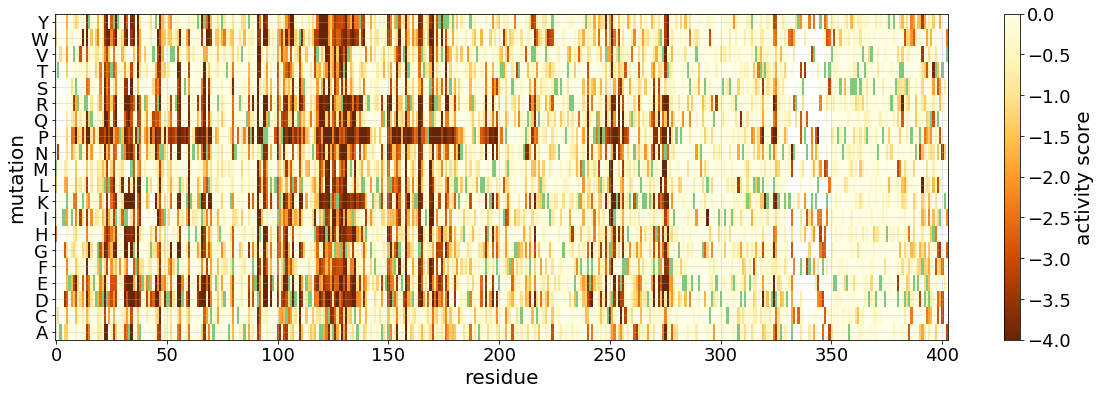

In [30]:
heatmap_scores(activity_PTEN_scores,'activity score',PTEN_WT_sequence,-4,0,'YlOrBr_r')
plt.savefig('./Figures/PTEN_heatmap_activity_MAVE.pdf')

- dataset coverage

In [31]:
count=0
count_gap_total=0
for i in range(activity_PTEN_scores.shape[0]):
    count_gap=0
    for j in range(0,20):
        if np.isnan(activity_PTEN_scores[i,j])==True:
            count_gap+=1
        count+=1
    count_gap_total+=count_gap
print("Variants coverage", 100-((count_gap_total-len(PTEN_WT_sequence))/count*100))

Variants coverage 95.07444168734492


- VAMP-seq abundance scores

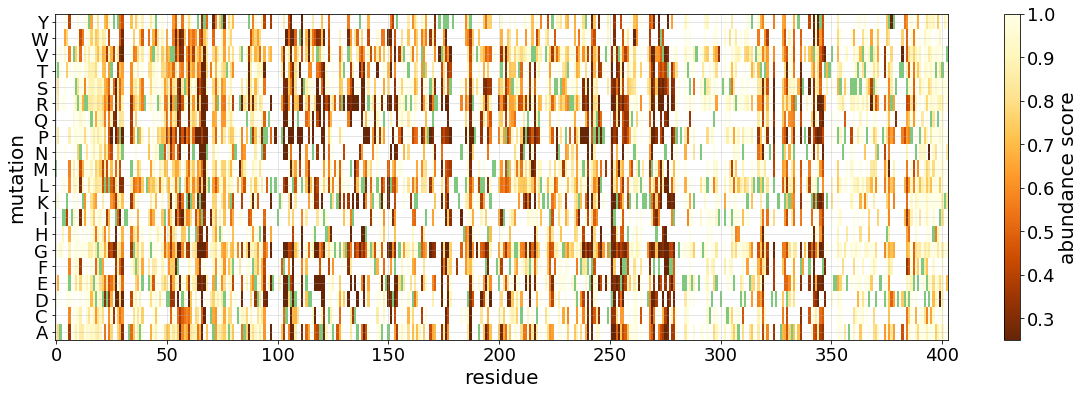

In [32]:
heatmap_scores(abundance_PTEN_scores,'abundance score',PTEN_WT_sequence,0.25,1,'YlOrBr_r')
plt.savefig('./Figures/PTEN_heatmap_abundance_MAVE.pdf')

- dataset coverage

In [33]:
count=0
count_gap_total=0
for i in range(abundance_PTEN_scores.shape[0]):
    count_gap=0
    for j in range(0,20):
        if np.isnan(abundance_PTEN_scores[i,j])==True:
            count_gap+=1
        count+=1
    count_gap_total+=count_gap
print("Variants coverage", 100-((count_gap_total-len(PTEN_WT_sequence))/count*100))

Variants coverage 56.01736972704715


### MAVE Score distribution Analysis
#### Phosphatase activity assay scores

Over threshold variants: 5160  ( 71.07438016528926 %)


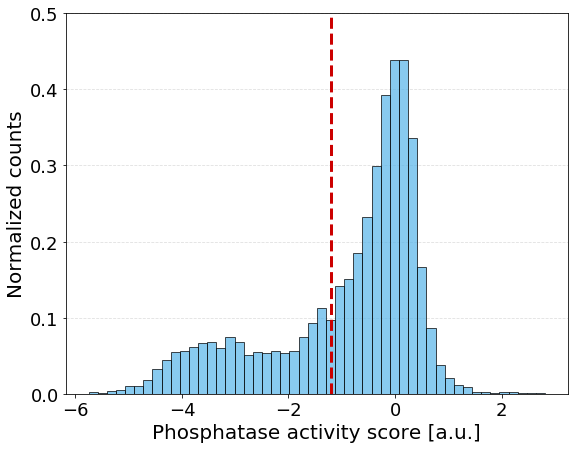

In [34]:
score_histogram(activity_PTEN_scores,50,'#56b4e9','Phosphatase activity score [a.u.]', 'True',-1.2)

y_size=[0,0.5]
vert_line = np.array( [-1.2 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=3)
plt.ylim(0,0.5)

plt.savefig('./Figures/PTEN_histo_act_MAVE.pdf')

##### Threshold definition: Tri-gaussian model fit

In [35]:
y,x,_=hist(activity_PTEN_scores[~np.isnan(activity_PTEN_scores)],100,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(-4,1,80,-1.8,0.2,100,0,.5,400)
params,cov=curve_fit(bimodal,x,y,p0=expected)
sigma=sqrt(diag(cov))
plt.close()

In [36]:
gaus_fit_params=pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
print(gaus_fit_params)

            params      sigma
mu1      -3.299840   0.072056
sigma1    0.919684   0.076551
A1       58.866400   2.901616
mu2      -0.631732   0.072549
sigma2    0.738385   0.039764
A2      134.539359   7.742288
mu3       0.066691   0.008051
sigma3    0.313807   0.011840
A3      302.943647  13.434600


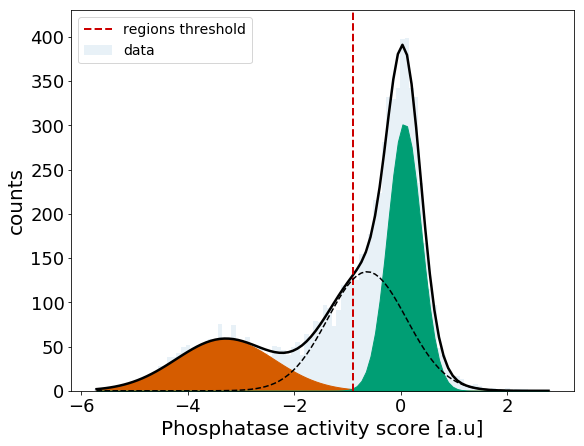

In [37]:
hist(activity_PTEN_scores[~np.isnan(activity_PTEN_scores)],100,alpha=.1,label='data')

plot(x,gauss(x,gaus_fit_params.iloc[3,0],gaus_fit_params.iloc[4,0],gaus_fit_params.iloc[5,0]),color='black',zorder=3,ls='--')
plt.fill_between(x,gauss(x,gaus_fit_params.iloc[0,0],gaus_fit_params.iloc[1,0],gaus_fit_params.iloc[2,0]),color='#D55C00',zorder=2)
plt.fill_between(x,gauss(x,gaus_fit_params.iloc[6,0],gaus_fit_params.iloc[7,0],gaus_fit_params.iloc[8,0]),color='#009E74',zorder=2)
plot(x,bimodal(x,*params),color='black',lw=2.5)
y_size=[0,430]
vert_line = np.array( [-0.9 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=2)
plt.xlabel("Phosphatase activity score [a.u]")
plt.ylabel("counts")
plt.ylim(0,430)
legend()
plt.savefig("./Figures/PTEN_experiment_activity_thresholds.pdf")

#### VAMP-seq abundance scores

Over threshold variants: 2784  ( 67.70428015564202 %)


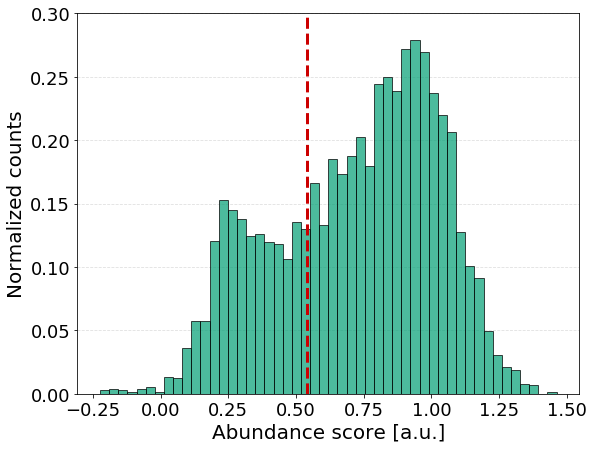

In [38]:
score_histogram(abundance_PTEN_scores,50,'#009e74','Abundance score [a.u.]', 'True',0.6)

y_size=[0,0.3]
vert_line = np.array( [0.54 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=3)
plt.ylim(0,0.3)

plt.savefig('./Figures/PTEN_histo_abd_MAVE.pdf')

##### Threshold definition: Tri-gaussian model fit

In [39]:
y,x,_=hist(abundance_PTEN_scores[~np.isnan(abundance_PTEN_scores)],100,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

params,cov=curve_fit(bimodal,x,y)#,p0=expected)
sigma=sqrt(diag(cov))
plt.close()

In [40]:
gaus_fit_params=pd.DataFrame(data={'params':params,'sigma':sigma},index=bimodal.__code__.co_varnames[1:])
print(gaus_fit_params)

           params      sigma
mu1      0.255114   0.007962
sigma1  -0.085318   0.010456
A1      39.836552   4.389226
mu2      0.690070   0.050766
sigma2   0.256661   0.028762
A2      61.797548   5.784911
mu3      0.973511   0.009061
sigma3  -0.127260   0.014557
A3      65.972806  12.580726


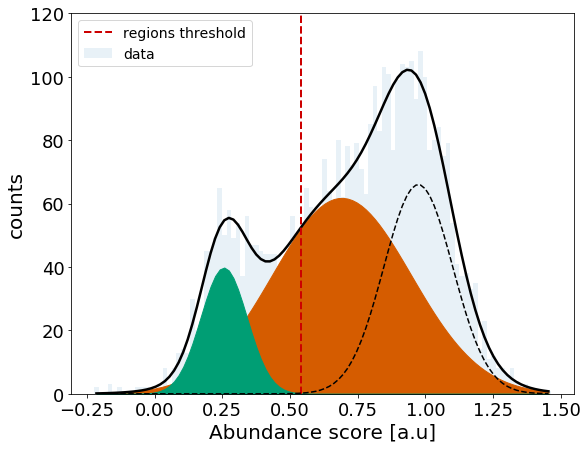

In [41]:
hist(abundance_PTEN_scores[~np.isnan(abundance_PTEN_scores)],100,alpha=.1,label='data')

plot(x,gauss(x,gaus_fit_params.iloc[6,0],gaus_fit_params.iloc[7,0],gaus_fit_params.iloc[8,0]),color='black',zorder=3,ls='--')
plt.fill_between(x,gauss(x,gaus_fit_params.iloc[3,0],gaus_fit_params.iloc[4,0],gaus_fit_params.iloc[5,0]),color='#D55C00',zorder=2)
plt.fill_between(x,gauss(x,gaus_fit_params.iloc[0,0],gaus_fit_params.iloc[1,0],gaus_fit_params.iloc[2,0]),color='#009E74',zorder=2)
plot(x,bimodal(x,*params),color='black',lw=2.5)
y_size=[0,120]
vert_line = np.array( [0.54 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=2)
plt.xlabel("Abundance score [a.u]")
plt.ylabel("counts")
plt.ylim(0,120)
legend()
plt.savefig("./Figures/PTEN_experiment_abundance_thresholds.pdf")

### MAVE scores combined 2D histogram

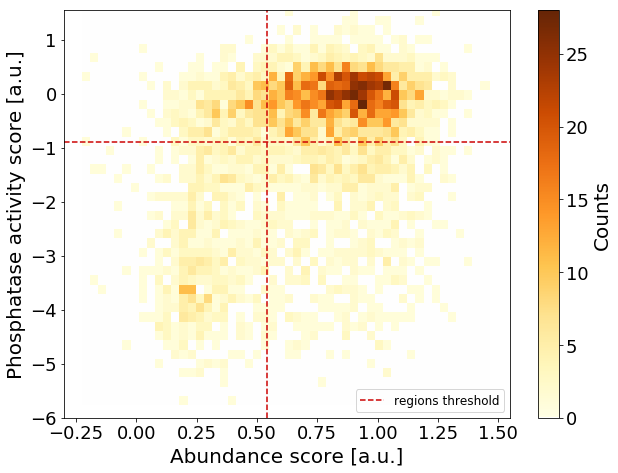

In [42]:
mpl.rcParams['figure.figsize']=(10,7.5)
y=[]; x=[]

# Custom threshold, already fixed on the single score distribution analysis
y_threshold=-0.9    # phosphatase activity assay scores
x_threshold=0.54    # abundance scores

x_size=[-0.30,1.55]
y_size=[-6,3]

# Create the vectors with the common dataset between the two experiment
# It remove a variant data if one of the two MAVE array contain a NA as score for that mutation.
for i in range(activity_PTEN_scores.shape[0]):
    for j in range(activity_PTEN_scores.shape[1]):
        if np.isnan(activity_PTEN_scores[i,j]) or np.isnan(abundance_PTEN_scores[i,j]):
            pass
        else:
            y.append(float(activity_PTEN_scores[i,j]))
            x.append(float(abundance_PTEN_scores[i,j]))

# Common variants assays
x=np.array(x)
y=np.array(y)

#Plot the 2D histogram
plt.xlabel("Abundance score [a.u.]")
plt.ylabel("Phosphatase activity score [a.u.]")

h, xedges, yedges,image = plt.hist2d(x,y,bins=50,cmap =newcmp)# norm=mpl.colors.LogNorm()
cbar = plt.colorbar(label="Counts")

horiz_line = np.array( [y_threshold for i in range(len(x_size))])
plt.plot(x_size, horiz_line, 'r--',color='#cc0000')

vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')

plt.legend(loc='lower right',fontsize=12)
plt.xlim(x_size[0],x_size[1])
plt.ylim(y_size[0],x_size[1])
plt.savefig('./Figures/PTEN_2d_histo_MAVE.pdf')
plt.show()

#### Phosphatase domain heatmap

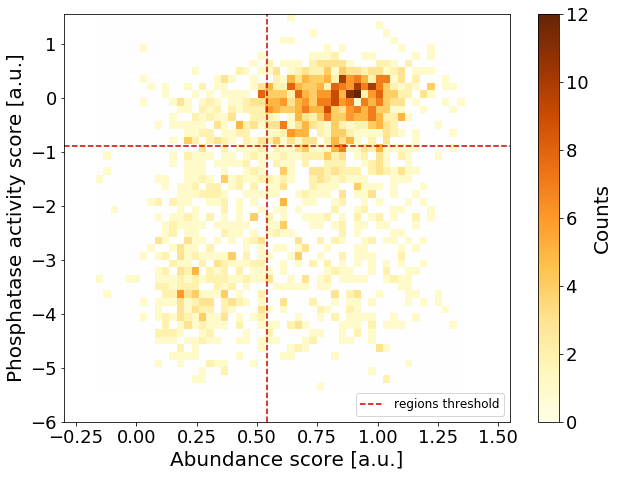

In [43]:
mpl.rcParams['figure.figsize']=(10,7.5)
y=[]; x=[]
# Custom threshold, already fixed on the single score distribution analysis
y_threshold=-0.9    # phosphatase activity assay scores
x_threshold=0.54     # abundance scores

x_size=[-0.30,1.55]
y_size=[-6,3]

# Create the vectors with the common dataset between the two experiment
# It remove a variant data if one of the two MAVE array contain a NA as score for that mutation.
for i in range(13,186):
    for j in range(activity_PTEN_scores.shape[1]):
        if np.isnan(activity_PTEN_scores[i,j]) or np.isnan(abundance_PTEN_scores[i,j]):
            pass
        else:
            y.append(float(activity_PTEN_scores[i,j]))
            x.append(float(abundance_PTEN_scores[i,j]))

# Common variants assays
x=np.array(x)
y=np.array(y)

#Plot the 2D histogram
plt.xlabel("Abundance score [a.u.]")
plt.ylabel("Phosphatase activity score [a.u.]")

h, xedges, yedges,image = plt.hist2d(x,y,bins=50,cmap =newcmp)# norm=mpl.colors.LogNorm()
cbar = plt.colorbar(label="Counts")

horiz_line = np.array( [y_threshold for i in range(len(x_size))])
plt.plot(x_size, horiz_line, 'r--',color='#cc0000')

vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')

plt.legend(loc='lower right',fontsize=12)
plt.xlim(x_size[0],x_size[1])
plt.ylim(y_size[0],x_size[1])
plt.savefig('./Figures/PTEN_2d_histo_MAVE_PD.pdf')
plt.show()

#### C2 domain heatmap

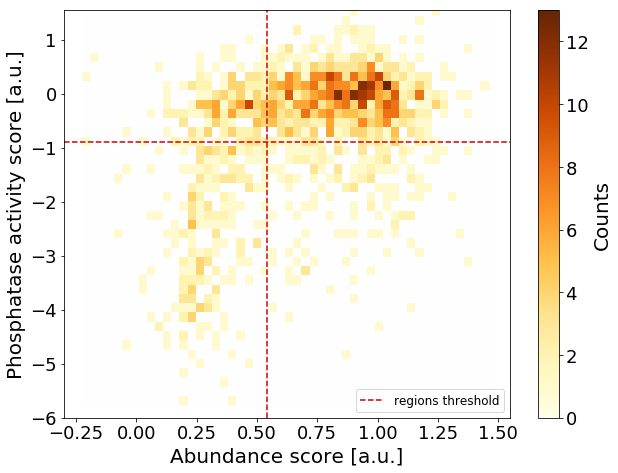

In [44]:
mpl.rcParams['figure.figsize']=(10,7.5)
y=[]; x=[]
# Custom threshold, already fixed on the single score distribution analysis
y_threshold=-0.9    # phosphatase activity assay scores
x_threshold=0.54     # abundance scores

x_size=[-0.30,1.55]
y_size=[-6,3]

# Create the vectors with the common dataset between the two experiment
# It remove a variant data if one of the two MAVE array contain a NA as score for that mutation.
for i in range(189,351):
    for j in range(activity_PTEN_scores.shape[1]):
        if np.isnan(activity_PTEN_scores[i,j]) or np.isnan(abundance_PTEN_scores[i,j]):
            pass
        else:
            y.append(float(activity_PTEN_scores[i,j]))
            x.append(float(abundance_PTEN_scores[i,j]))

# Common variants assays
x=np.array(x)
y=np.array(y)

#Plot the 2D histogram
plt.xlabel("Abundance score [a.u.]")
plt.ylabel("Phosphatase activity score [a.u.]")

h, xedges, yedges,image = plt.hist2d(x,y,bins=50,cmap =newcmp)# norm=mpl.colors.LogNorm()
cbar = plt.colorbar(label="Counts")

horiz_line = np.array( [y_threshold for i in range(len(x_size))])
plt.plot(x_size, horiz_line, 'r--',color='#cc0000')

vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')

plt.legend(loc='lower right',fontsize=12)
plt.xlim(x_size[0],x_size[1])
plt.ylim(y_size[0],x_size[1])
plt.savefig('./Figures/PTEN_2d_histo_MAVE_C2D.pdf')
plt.show()

### Color residues classification
Based on the location of the variants ion the previous 2d histogram and using the designed thresholds
- (1) upper right: stable and functional - GREEN
- (2) upper left: unstable and fuctional - YELLOW
- (3) lower right: stable and unfunctional - BLUE
- (4) lower left: unstable and unfunctional -RED

In [45]:
class_labels_residues_exp=np.empty((len(PTEN_WT_sequence),20),dtype=float)
class_labels_residues_exp[:]=np.nan

In [46]:
# Assign the color to the variant based on its position in the 2d combined histogram
for i in range(class_labels_residues_exp.shape[0]):
    for j in range(class_labels_residues_exp.shape[1]):
        if np.isnan(activity_PTEN_scores[i,j]) or np.isnan(abundance_PTEN_scores[i,j]):
            pass
        else:
            if activity_PTEN_scores[i,j] <= y_threshold:
                if abundance_PTEN_scores[i,j] <= x_threshold:
                    class_labels_residues_exp[i,j]=1
                else:
                    class_labels_residues_exp[i,j]=3
            else:
                if abundance_PTEN_scores[i,j] <= x_threshold:
                    class_labels_residues_exp[i,j]=2
                else:
                    class_labels_residues_exp[i,j]=4

In [47]:
# Print information about the number of variants in each color region
counts = count_variants_regions(class_labels_residues_exp)
print('Variants per region:')
print(counts)
counts_perc = (counts/ np.sum(counts))*100
print('Variants per region percentage:')
print(counts_perc)

Variants per region:
[[ 703]
 [ 402]
 [ 720]
 [2102]]
Variants per region percentage:
[[17.90170614]
 [10.236822  ]
 [18.33460657]
 [53.52686529]]


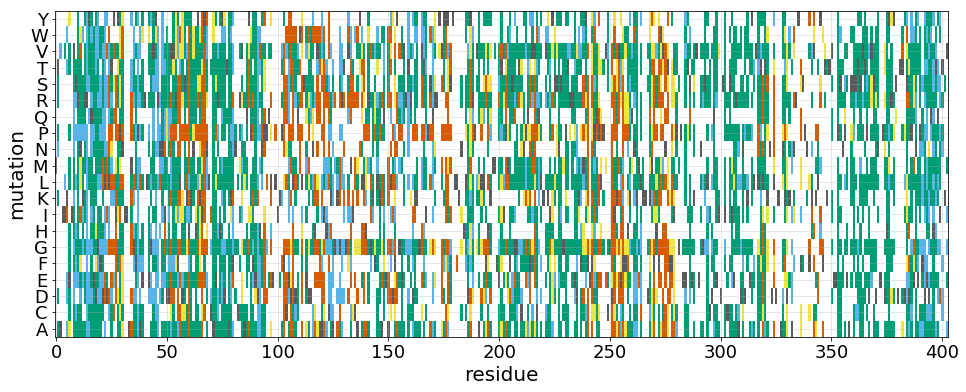

In [48]:
#Heatmap of the variant color classification
heatmap_classification_WT(class_labels_residues_exp,PTEN_WT_sequence)
plt.savefig('./Figures/PTEN_region_heatmap_MAVE.pdf')

- dataset coverage

In [49]:
count=0
count_gap_total=0
for i in range(class_labels_residues_exp.shape[0]):
    count_gap=0
    for j in range(0,20):
        if np.isnan(class_labels_residues_exp[i,j])==True:
            count_gap+=1
        count+=1
    count_gap_total+=count_gap
print("Variants coverage", 100-((count_gap_total-len(PTEN_WT_sequence))/count*100))

Variants coverage 53.72208436724566


#### Phosphatase domain count percentage

In [50]:
class_labels_residues_exp_dom=np.empty((len(PTEN_WT_sequence),20),dtype=float)
class_labels_residues_exp_dom[:]=np.nan

In [51]:
# Assign the color to the variant based on its position in the 2d combined histogram
for i in range(13,186):
    for j in range(class_labels_residues_exp_dom.shape[1]):
        if np.isnan(activity_PTEN_scores[i,j]) or np.isnan(abundance_PTEN_scores[i,j]):
            pass
        else:
            if activity_PTEN_scores[i,j] <= y_threshold:
                if abundance_PTEN_scores[i,j] <= x_threshold:
                    class_labels_residues_exp_dom[i,j]=1
                else:
                    class_labels_residues_exp_dom[i,j]=3
            else:
                if abundance_PTEN_scores[i,j] <= x_threshold:
                    class_labels_residues_exp_dom[i,j]=2
                else:
                    class_labels_residues_exp_dom[i,j]=4

In [52]:
# Print information about the number of variants in each color region
counts = count_variants_regions(class_labels_residues_exp_dom)
print('Variants per region:')
print(counts)
counts_perc = (counts/ np.sum(counts))*100
print('Variants per region percentage:')
print(counts_perc)

Variants per region:
[[427]
 [153]
 [428]
 [812]]
Variants per region percentage:
[[23.46153846]
 [ 8.40659341]
 [23.51648352]
 [44.61538462]]


#### C2 domain count percentage

In [53]:
class_labels_residues_exp_dom=np.empty((len(PTEN_WT_sequence),20),dtype=float)
class_labels_residues_exp_dom[:]=np.nan

In [54]:
# Assign the color to the variant based on its position in the 2d combined histogram
for i in range(189,351):
    for j in range(class_labels_residues_exp_dom.shape[1]):
        if np.isnan(activity_PTEN_scores[i,j]) or np.isnan(abundance_PTEN_scores[i,j]):
            pass
        else:
            if activity_PTEN_scores[i,j] <= y_threshold:
                if abundance_PTEN_scores[i,j] <= x_threshold:
                    class_labels_residues_exp_dom[i,j]=1
                else:
                    class_labels_residues_exp_dom[i,j]=3
            else:
                if abundance_PTEN_scores[i,j] <= x_threshold:
                    class_labels_residues_exp_dom[i,j]=2
                else:
                    class_labels_residues_exp_dom[i,j]=4

In [55]:
# Print information about the number of variants in each color region
counts = count_variants_regions(class_labels_residues_exp_dom)
print('Variants per region:')
print(counts)
counts_perc = (counts/ np.sum(counts))*100
print('Variants per region percentage:')
print(counts_perc)

Variants per region:
[[257]
 [207]
 [160]
 [834]]
Variants per region percentage:
[[17.62688615]
 [14.19753086]
 [10.9739369 ]
 [57.20164609]]


### Most common variant colour residue classification

In [56]:
# Use the most common value to define color for each residue
mode_value_class_PTEN_exp=np.zeros(len(PTEN_WT_sequence))

In [57]:
# Statistic on the number of residues per each region
for i in range(len(PTEN_WT_sequence)):
    mode_value_class_PTEN_exp, counts_mode=sp.stats.mode(class_labels_residues_exp,axis=1)

for i in range(1,5):
    count=0
    count_tot=0
    for j in range(len(mode_value_class_PTEN_exp)):
        if np.isnan(mode_value_class_PTEN_exp[j]) != True:
            count_tot+=1
        if mode_value_class_PTEN_exp[j]==i:
            count+=1
    print( "There are ", count," out of ",count_tot,"(",(count/count_tot)*100, "%)"  " residues in region",i)

There are  78  out of  355 ( 21.971830985915496 %) residues in region 1
There are  21  out of  355 ( 5.915492957746479 %) residues in region 2
There are  41  out of  355 ( 11.549295774647888 %) residues in region 3
There are  215  out of  355 ( 60.56338028169014 %) residues in region 4


In [58]:
# The results are show only for positions that have data for more than 5 mutations
y2_exp=np.copy(mode_value_class_PTEN_exp)
for i in range(len(mode_value_class_PTEN_exp)):
    if counts_mode[i] <5:
        y2_exp[i]=np.nan

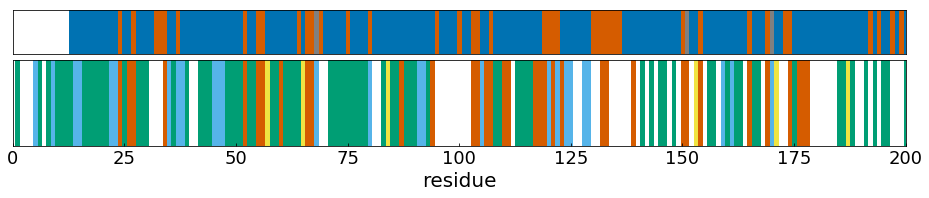

In [59]:
# Plot of the residue color classification and comparison with the solvent accessibility classification
#PART 1: residue 1-200
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,2.5),gridspec_kw={"height_ratios" : [1.5,3], "hspace" : 0.1})

x=[ i for i in range(len(PTEN_WT_sequence)) ]
x=np.array(x)

y=solvent_acc_PTEN

#color code Solvent Accessibility analysis: green-exposed, gray-uncertain, red-buried
ax1.imshow(np.transpose(y),aspect='auto',cmap=mpl.colors.ListedColormap(["#d55c00",'gray',"#0072B2"]))

ax2.imshow(np.transpose(y2_exp), aspect = 'auto', cmap=mpl.colors.ListedColormap(["#d55c00", "#f0e442", "#56b4e9", "#009e74"]))

ax1.set_xlim(0,200)
ax2.set_xlim(0,200)

ax1.set_yticks([],[])
ax1.set_xticks([],[])

ax2.set_xlabel('residue',fontsize=20)
ax2.set_yticks([],[])

plt.tick_params(
    axis='y',         
    which='both',      
    left=False,
    labelleft=False) 

plt.tick_params(
    axis='x',         
    which='both',
    direction='in')

plt.savefig('./Figures/PTEN_color_class_sa_MAVE_part1.pdf', bbox_inches='tight')

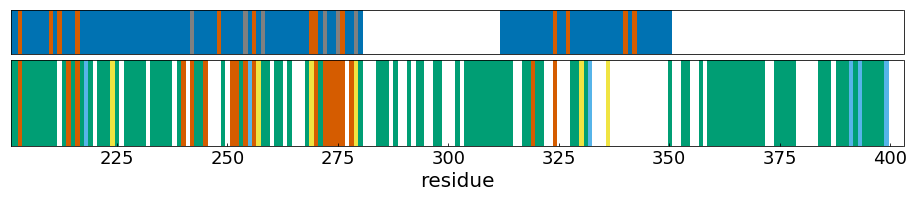

In [60]:
# Plot of the residue color classification and comparison with the solvent accessibility classification
#PART 2: residue 200-=403
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,2.5),gridspec_kw={"height_ratios" : [1.5,3], "hspace" : 0.1})

x=[ i for i in range(len(PTEN_WT_sequence)) ]
x=np.array(x)

y=solvent_acc_PTEN

#color code Solvent Accessibility analysis: green-exposed, gray-uncertain, red-buried
ax1.imshow(np.transpose(y),aspect='auto',cmap=mpl.colors.ListedColormap(["#d55c00",'gray',"#0072B2"]))

ax2.imshow(np.transpose(y2_exp), aspect = 'auto', cmap=mpl.colors.ListedColormap(["#d55c00", "#f0e442", "#56b4e9", "#009e74"]))

ax1.set_xlim(201,403)
ax2.set_xlim(201,403)

ax1.set_yticks([],[])
ax1.set_xticks([],[])

ax2.set_xlabel('residue',fontsize=20)
ax2.set_yticks([],[])

plt.tick_params(
    axis='y',         
    which='both',      
    left=False,
    labelleft=False) 

plt.tick_params(
    axis='x',         
    which='both',
    direction='in')

plt.savefig('./Figures/PTEN_color_class_sa_MAVE_part2.pdf', bbox_inches='tight')

Statistic on solvent accessibility matched regions:

In [61]:
print('red label - buried')
count=0
count_total=0
for i in range(len(PTEN_WT_sequence)):
    if np.isnan(y[i])!=True and np.isnan(y2_exp[i])!= True:
        if y[i]==0:
            count_total+=1
            if y2_exp[i]==1:
                count+=1
print(count,' ', count_total, ', percentage:',count/count_total*100)

print('yellow label - buried')
count=0
count_total=0
for i in range(len(PTEN_WT_sequence)):
    if np.isnan(y[i])!=True and np.isnan(y2_exp[i])!= True:
        if y[i]==0:
            count_total+=1
            if y2_exp[i]==2:
                count+=1
print(count,' ', count_total, ', percentage:',count/count_total*100)

print('blue label - buried')
count=0
count_total=0
for i in range(len(PTEN_WT_sequence)):
    if np.isnan(y[i])!=True and np.isnan(y2_exp[i])!= True:
        if y[i]==0:
            count_total+=1
            if y2_exp[i]==3:
                count+=1
print(count,' ', count_total, ', percentage:',count/count_total*100)

print('green label - buried')
count=0
count_total=0
for i in range(len(PTEN_WT_sequence)):
    if np.isnan(y[i])!=True and np.isnan(y2_exp[i])!= True:
        if y[i]==0:
            count_total+=1
            if y2_exp[i]==4:
                count+=1
print(count,' ', count_total, ', percentage:',count/count_total*100)

red label - buried
26   34 , percentage: 76.47058823529412
yellow label - buried
1   34 , percentage: 2.941176470588235
blue label - buried
4   34 , percentage: 11.76470588235294
green label - buried
3   34 , percentage: 8.823529411764707


### Error evaluation on experimental variants
Using a gaussian sampling of variant scores, we evaluate the robustness of our classification and how many variants and residues can change class.
The code is commented due to long execution time(>3h). You can run it to obtain the mean and percentage for each region.

In [62]:
#PTEN_sampling_region_counts, PTEN_sampling_region_percentages, PTEN_sampling_residue_label_counts=gaussian_sampling_regions(activity_PTEN_scores,abundance_PTEN_scores,activity_PTEN_errors,abundance_PTEN_errors,x_threshold,y_threshold,100000)

In [63]:
#print(PTEN_sampling_region_counts)
#print(PTEN_sampling_region_percentages)

## Computational analysis

### Heatmaps computational scores
- Rosetta scores

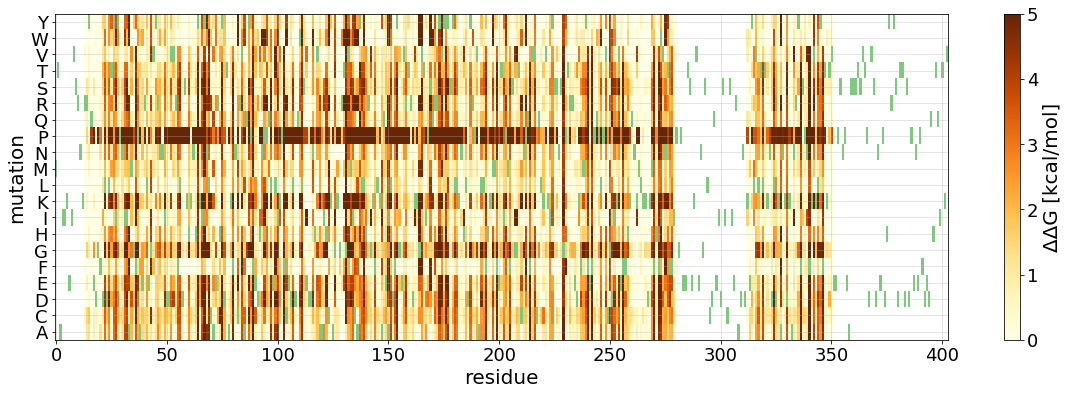

In [64]:
heatmap_scores(rosetta_PTEN_ddg,'\u0394\u0394G [kcal/mol]',PTEN_WT_sequence,0,5,'YlOrBr')
plt.savefig('./Figures/PTEN_heatmap_rosetta_COMP.pdf')

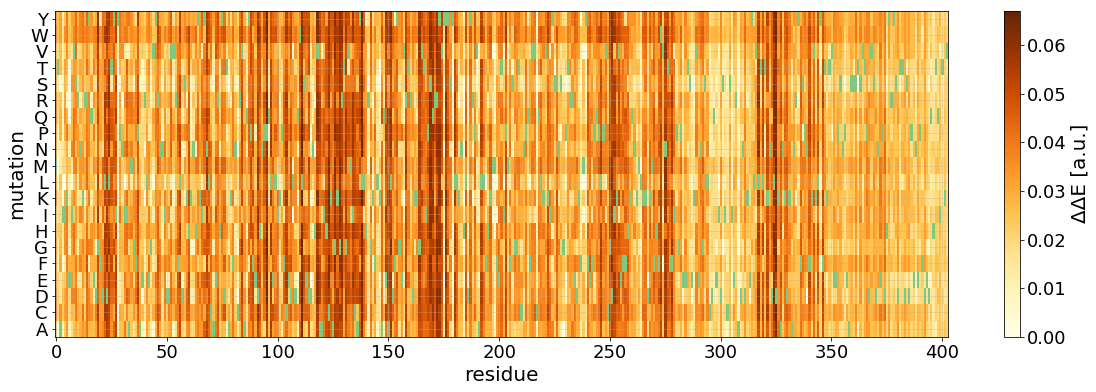

In [65]:
heatmap_scores(coevo_PTEN_scores,'\u0394\u0394E [a.u.]',PTEN_WT_sequence,0,np.amax(coevo_PTEN_scores[~np.isnan(coevo_PTEN_scores)]),'YlOrBr')
plt.savefig('./Figures/PTEN_heatmap_coevo_COMP.pdf')

In [66]:
#select the common data subset between the two algorithms
common_activity_PTEN_scores=np.empty((len(PTEN_WT_sequence),20),dtype=float)
common_activity_PTEN_scores[:]=np.nan

common_abundance_PTEN_scores=np.empty((len(PTEN_WT_sequence),20),dtype=float)
common_abundance_PTEN_scores[:]=np.nan

for i in range(len(PTEN_WT_sequence)):
    for j in range(20):
        if np.isnan(activity_PTEN_scores[i,j]) == False and np.isnan(abundance_PTEN_scores[i,j]) == False:
            common_activity_PTEN_scores[i,j]=activity_PTEN_scores[i,j]
            common_abundance_PTEN_scores[i,j]=abundance_PTEN_scores[i,j]

### Pearson's correlation coefficient with MAVE experiments
- Phosphatase Activity MAVE vs Co-evolution scores

Pearson's correlation coefficient between data:  -0.47630968487149394
Pearson's correlation coefficient between data:  -0.44415917478988914


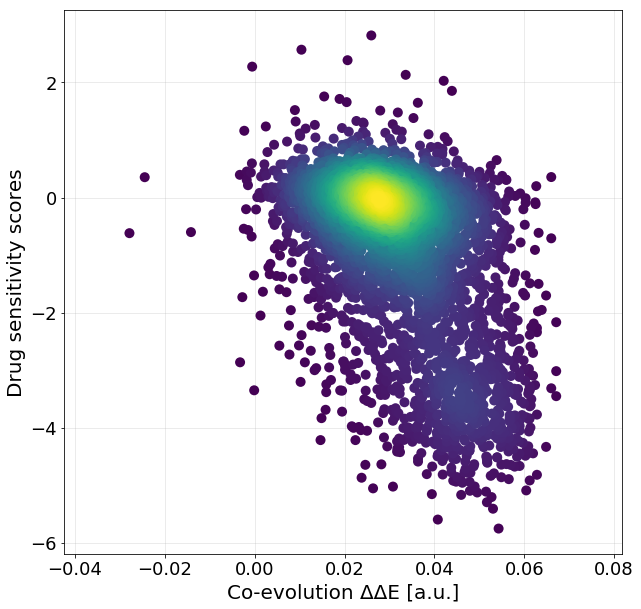

In [67]:
pearson_PTEN_act_coevo=scores_density_plot(coevo_PTEN_scores,common_activity_PTEN_scores,"Co-evolution \u0394\u0394E [a.u.]", "Drug sensitivity scores")


- Phosphatase Activity MAVE vs Rosetta scores

Pearson's correlation coefficient between data:  -0.38282377061685385
Pearson's correlation coefficient between data:  -0.3167128660027976


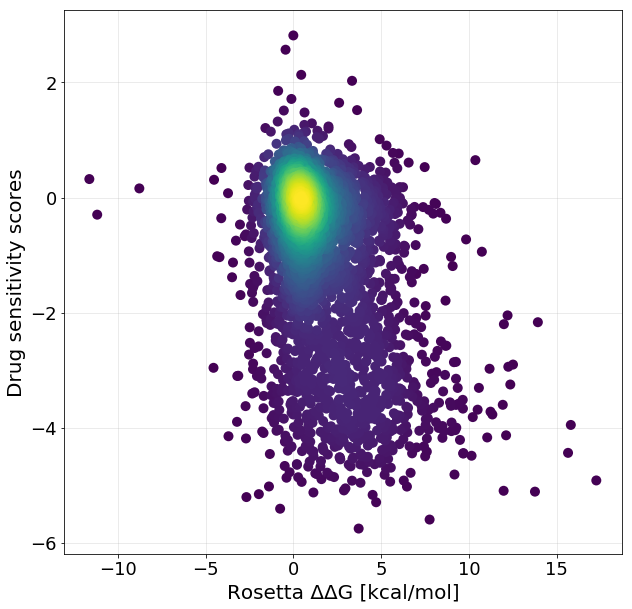

In [68]:
pearson_PTEN_act_rosetta=scores_density_plot(rosetta_PTEN_ddg,common_activity_PTEN_scores,"Rosetta \u0394\u0394G [kcal/mol]", "Drug sensitivity scores")

- VAMP-seq MAVE vs Co-evolution scores

Pearson's correlation coefficient between data:  -0.46981198436855165
Pearson's correlation coefficient between data:  -0.467160729951763


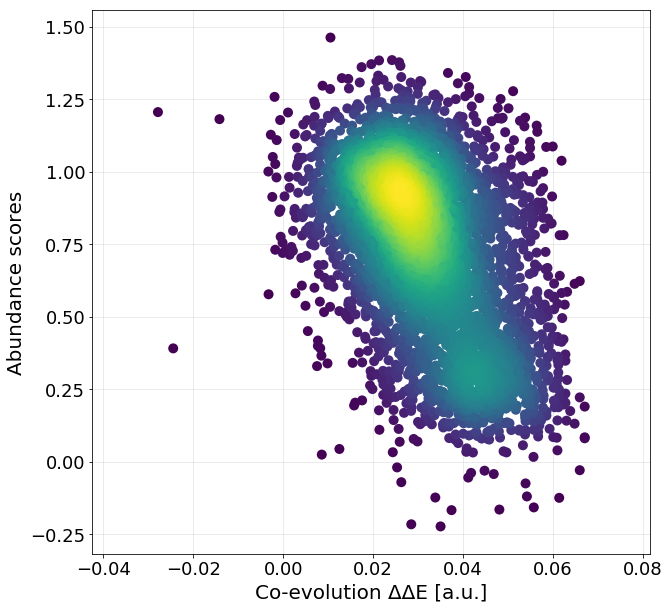

In [69]:
pearson_PTEN_abd_coevo=scores_density_plot(coevo_PTEN_scores,common_abundance_PTEN_scores,"Co-evolution \u0394\u0394E [a.u.]", "Abundance scores")

- VAMP-seq MAVE vs Rosetta scores

Pearson's correlation coefficient between data:  -0.48133298669148983
Pearson's correlation coefficient between data:  -0.4877154511837087


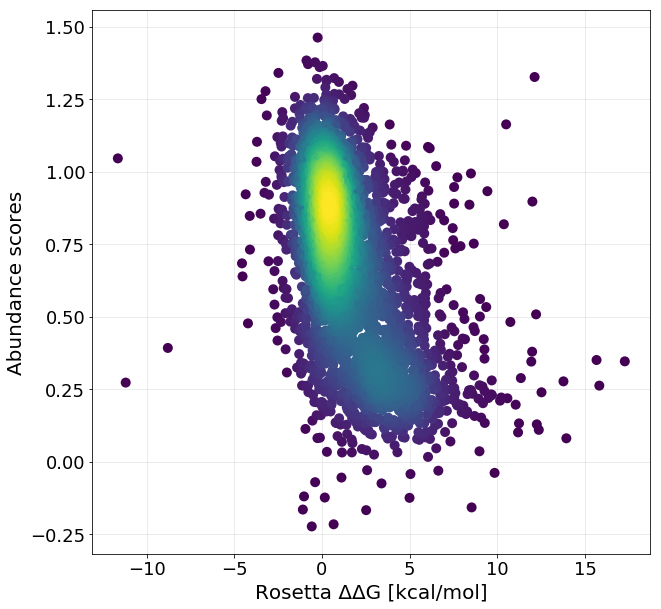

In [70]:
pearson_PTEN_abd_rosetta=scores_density_plot(rosetta_PTEN_ddg,common_abundance_PTEN_scores,"Rosetta \u0394\u0394G [kcal/mol]", "Abundance scores")

### Computational score distribution analysis
- Rosetta abundance scores

Over threshold variants: 2398  ( 41.11092062403566 %)


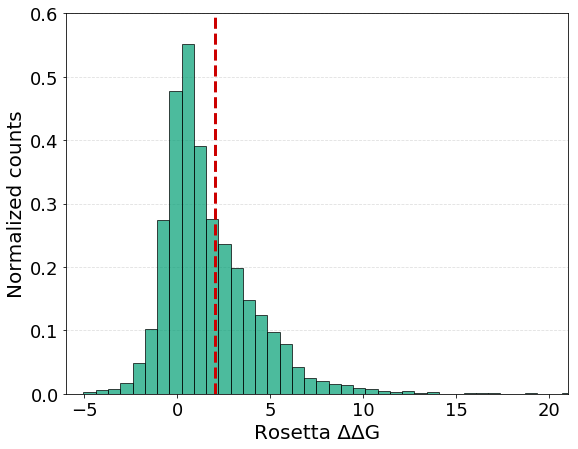

In [71]:
score_histogram(rosetta_PTEN_ddg,50,'#009e74','Rosetta \u0394\u0394G', 'True',2.0)

y_size=[0,1]
vert_line = np.array( [2.0 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=3)
plt.ylim(0,0.6)
plt.xlim(-6,21)
plt.savefig('./Figures/PTEN_rosetta_COMP.pdf')

- Co-evolution energies histogram

Over threshold variants: 2781  ( 36.31970745722868 %)


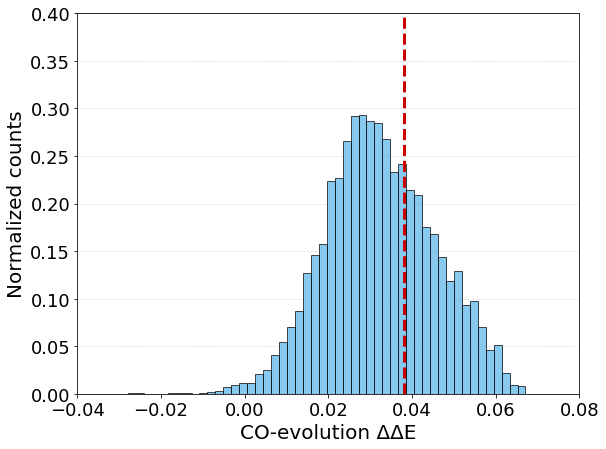

In [72]:
score_histogram(coevo_PTEN_scores,50,'#56b4e9','CO-evolution \u0394\u0394E','True',0.038)

y_size=[0,1]
vert_line = np.array( [0.038 for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000',lw=3)
plt.ylim(0,0.4)
plt.xlim(-0.04,0.08)
plt.savefig('./Figures/PTEN_coevo_COMP.pdf')

### Computational scores combined 2D histogram

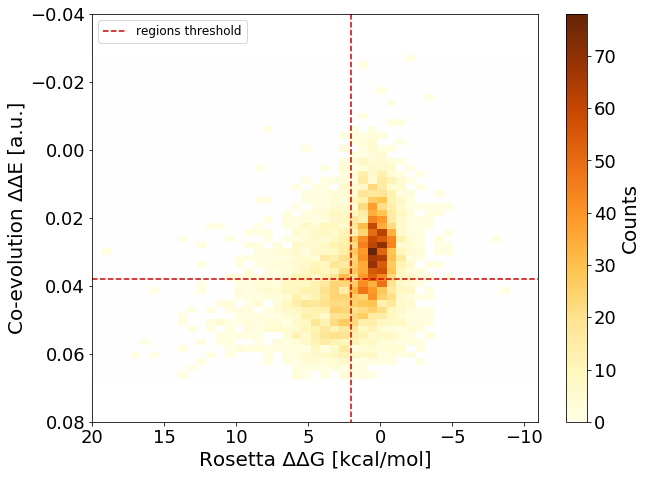

In [73]:
mpl.rcParams['figure.figsize']=(10,7.5)
y=[]; x=[]

# Custom threshold, already fixed on the single score distribution analysis
y_threshold=0.038    #Co-evolution score threshold
x_threshold=2.0    # Rosetta score threshold

x_size=[20,-11]
y_size=[-0.04,0.08]

# Create the vectors with the common dataset between the two experiment
# It remove a variant data if one of the two MAVE array contain a NA as score for that mutation.
for i in range(coevo_PTEN_scores.shape[0]):
    for j in range(coevo_PTEN_scores.shape[1]):
        if np.isnan(coevo_PTEN_scores[i,j]) or np.isnan(rosetta_PTEN_ddg[i,j]):
            pass
        else:
            y.append(float(coevo_PTEN_scores[i,j]))
            x.append(float(rosetta_PTEN_ddg[i,j]))

# Common variant assays
x=np.array(x)
y=np.array(y)

#Plot the 2d histogram
plt.xlabel("Rosetta \u0394\u0394G [kcal/mol]")
plt.ylabel("Co-evolution \u0394\u0394E [a.u.]")
plt.hist2d(x,y,bins=50,cmap =newcmp)# norm=mpl.colors.LogNorm()
cbar = plt.colorbar(label="Counts")

horiz_line = np.array( [y_threshold for i in range(len(x_size))])
plt.plot(x_size, horiz_line, 'r--',color='#cc0000') 

vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')

plt.legend(loc='upper left',fontsize=12)
plt.xlim(x_size[0],x_size[1])
plt.ylim(y_size[1],y_size[0])
plt.savefig('./Figures/PTEN_2d_histo_COMP.pdf')

### Color residues classification
Based on the location of the variants ion the previous 2d histogram and using the designed thresholds
- (1) upper right: stable and functional - GREEN
- (2) upper left: unstable and fuctional - YELLOW
- (3) lower right: stable and unfunctional - BLUE
- (4) lower left: unstable and unfunctional -RED

In [74]:
class_labels_residues=np.empty((len(PTEN_WT_sequence),20),dtype=float)
class_labels_residues[:]=np.nan

In [75]:
# Assign the color to the variant based on its position in the 2d combined histogram

for i in range(class_labels_residues.shape[0]):
    for j in range(class_labels_residues.shape[1]):
        if np.isnan(coevo_PTEN_scores[i,j]) or np.isnan(rosetta_PTEN_ddg[i,j]):
            pass
        else:
            if coevo_PTEN_scores[i,j] <= y_threshold:
                if rosetta_PTEN_ddg[i,j] <= x_threshold:
                    class_labels_residues[i,j]=4
                else:
                    class_labels_residues[i,j]=2
            else:
                if rosetta_PTEN_ddg[i,j] <= x_threshold:
                    class_labels_residues[i,j]=3
                else:
                    class_labels_residues[i,j]=1

In [76]:
counts = count_variants_regions(class_labels_residues)
print('Variants per region:')
print(counts)
counts_perc = (counts/ np.sum(counts))*100
print('Variants per region percentage:')
print(counts_perc)

Variants per region:
[[1304]
 [ 734]
 [1138]
 [2657]]
Variants per region percentage:
[[22.35556318]
 [12.5835762 ]
 [19.50968627]
 [45.55117435]]


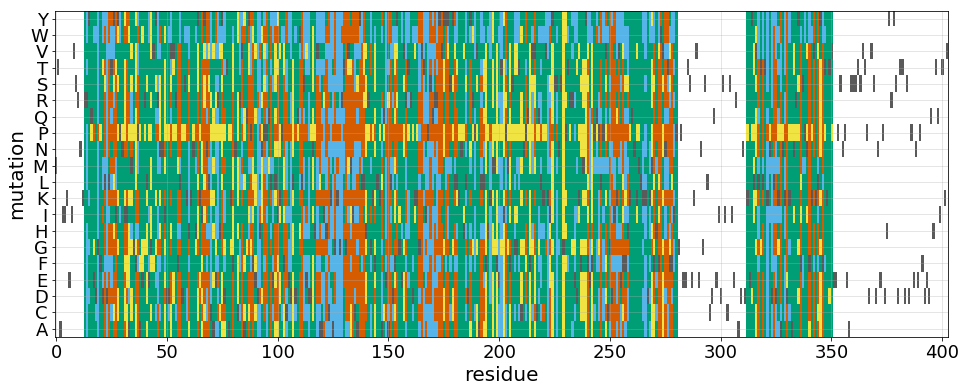

In [77]:
heatmap_classification_WT(class_labels_residues,PTEN_WT_sequence)
# plt.savefig('./Figures/PTEN_2d_heatmap_COMP.pdf')

### Residues most common variant colour classification

In [78]:
# Use the most common value to define acolor for each residue
mode_value_class=np.zeros(len(PTEN_WT_sequence))

In [79]:
for i in range(len(PTEN_WT_sequence)):
    mode_value_class, counts_mode=sp.stats.mode(class_labels_residues,axis=1)

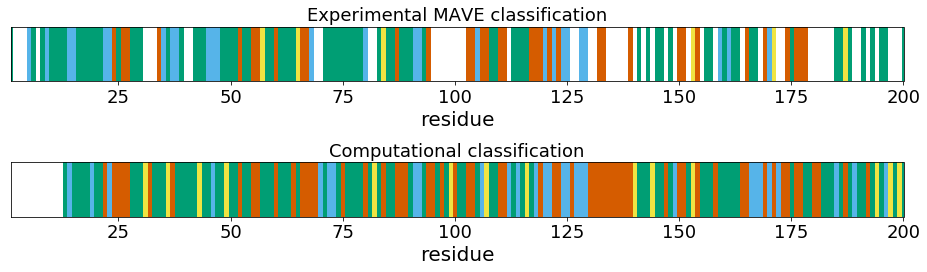

In [80]:
# Comparison with experimental MAVE residue colour classification
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,3.5),gridspec_kw={"height_ratios" : [3,3], "hspace" : 1.5})
ax1.imshow(np.transpose(y2_exp), aspect = 'auto',
           cmap=mpl.colors.ListedColormap(["#d55c00" , "#f0e442","#56b4e9", "#009e74"]))

ax2.imshow(np.transpose(mode_value_class),aspect= 'auto', cmap=mpl.colors.ListedColormap(["#d55c00", "#f0e442", "#56b4e9", "#009e74"]))
ax1.set_yticks([],[])
ax2.set_yticks([],[])
ax1.set_xlabel('residue')
ax2.set_xlabel('residue')

ax1.set_xlim(1,200)
ax2.set_xlim(1,200)

ax1.set_title('Experimental MAVE classification', fontsize='18')
ax2.set_title('Computational classification', fontsize='18')

plt.xlabel("residue")
plt.savefig('./Figures/PTEN_mode_comparison.pdf')

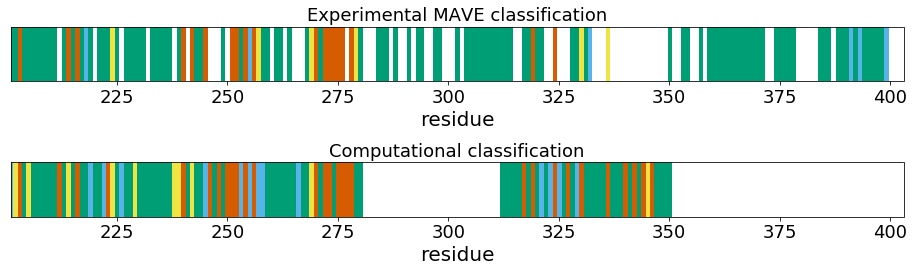

In [81]:
# Comparison with experimental MAVE residue colour classification
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,3.5),gridspec_kw={"height_ratios" : [3,3], "hspace" : 1.5})
ax1.imshow(np.transpose(y2_exp), aspect = 'auto',
           cmap=mpl.colors.ListedColormap(["#d55c00" , "#f0e442","#56b4e9", "#009e74"]))

ax2.imshow(np.transpose(mode_value_class),aspect= 'auto', cmap=mpl.colors.ListedColormap(["#d55c00", "#f0e442", "#56b4e9", "#009e74"]))
ax1.set_yticks([],[])
ax2.set_yticks([],[])
ax1.set_xlabel('residue')
ax2.set_xlabel('residue')

ax1.set_xlim(201,403)
ax2.set_xlim(201,403)

ax1.set_title('Experimental MAVE classification', fontsize='18')
ax2.set_title('Computational classification', fontsize='18')

plt.xlabel("residue")
plt.savefig('./Figures/PTEN_mode_comparison2.pdf')

In [82]:
for i in range(len(y2_exp)):
    if y2_exp[i]==3 and mode_value_class[i]==3:
        print(i,'',end='')

14 23 46 91 92 120 124 125 128 129 170 255 

### MAVE coloured variants distribution in computational scores
- Red variants

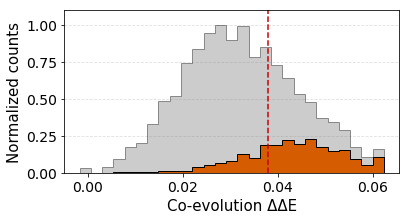

In [83]:
classification_histogram_shadowed(coevo_PTEN_scores,class_labels_residues_exp,40,0.00,0.06,'#d55c00',"Co-evolution \u0394\u0394E",1)
y_size=[0,1.2]
vert_line = np.array( [y_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/PTEN_comp_coevo_red_histo.pdf', bbox_inches='tight')

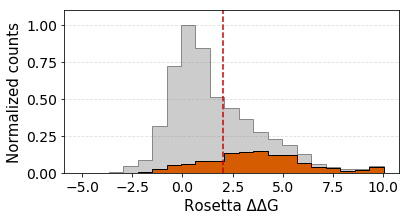

In [84]:
classification_histogram_shadowed(rosetta_PTEN_ddg,class_labels_residues_exp,40,-5,10,'#d55c00',"Rosetta \u0394\u0394G",1)

y_size=[0,1.2]
vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/PTEN_comp_rosetta_red_histo.pdf', bbox_inches='tight')

- Yellow variants

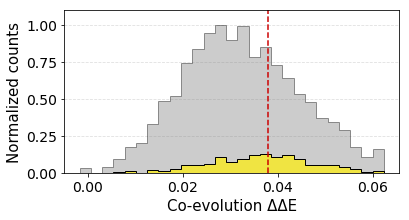

In [85]:
classification_histogram_shadowed(coevo_PTEN_scores,class_labels_residues_exp,40,0.00,0.06,'#f0e442',"Co-evolution \u0394\u0394E",2)
y_size=[0,1.2]
vert_line = np.array( [y_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/PTEN_comp_coevo_yellow_histo.pdf', bbox_inches='tight')

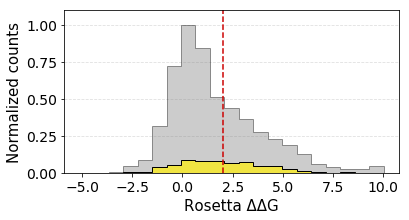

In [86]:
classification_histogram_shadowed(rosetta_PTEN_ddg,class_labels_residues_exp,40,-5,10,'#f0e442',"Rosetta \u0394\u0394G",2)

y_size=[0,1.2]
vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/PTEN_comp_rosetta_yellow_histo.pdf', bbox_inches='tight')

- Blue variants

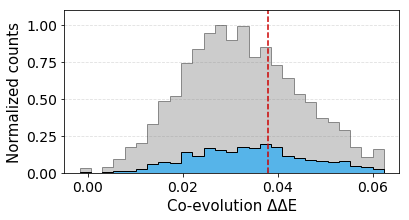

In [87]:
classification_histogram_shadowed(coevo_PTEN_scores,class_labels_residues_exp,40,0.00,0.06,'#56b4e9',"Co-evolution \u0394\u0394E",3)
y_size=[0,1.2]
vert_line = np.array( [y_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/PTEN_comp_coevo_blue_histo.pdf', bbox_inches='tight')

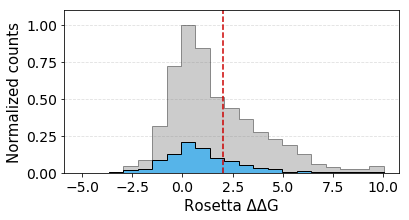

In [88]:
classification_histogram_shadowed(rosetta_PTEN_ddg,class_labels_residues_exp,40,-5,10,'#56b4e9',"Rosetta \u0394\u0394G",3)

y_size=[0,1.2]
vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/PTEN_comp_rosetta_blue_histo.pdf', bbox_inches='tight')

- Green variants

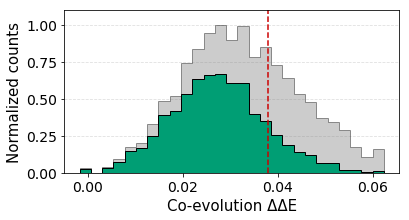

In [89]:
classification_histogram_shadowed(coevo_PTEN_scores,class_labels_residues_exp,40,0.00,0.06,'#009e74',"Co-evolution \u0394\u0394E",4)
y_size=[0,1.2]
vert_line = np.array( [y_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/PTEN_comp_coevo_green_histo.pdf', bbox_inches='tight')

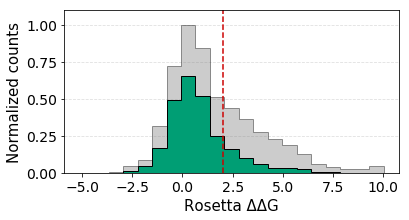

In [90]:
classification_histogram_shadowed(rosetta_PTEN_ddg,class_labels_residues_exp,40,-5,10,'#009e74',"Rosetta \u0394\u0394G",4)

y_size=[0,1.2]
vert_line = np.array( [x_threshold for i in range(len(y_size))])
plt.plot(vert_line,y_size, 'r--', label='regions threshold',color='#cc0000')
plt.ylim(0,1.1)
plt.savefig('./Figures/PTEN_comp_rosetta_green_histo.pdf', bbox_inches='tight')

### Comparison between the different computational methods and MAVE experiments

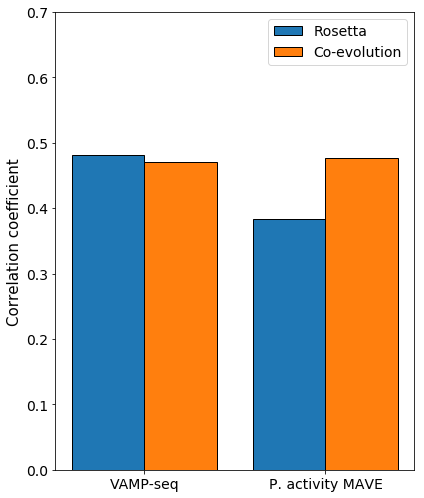

In [91]:
labels =['VAMP-seq', 'P. activity MAVE']
rosetta_bar=[-pearson_PTEN_abd_rosetta,-pearson_PTEN_act_rosetta]
coevo_bar=[-pearson_PTEN_abd_coevo,-pearson_PTEN_act_coevo]

x=np.arange(len(labels))
width=0.40

fig, ax =plt.subplots(figsize=(6,7))
rects1=ax.bar(x-width/2,rosetta_bar,width,label='Rosetta',edgecolor='black')
rects2=ax.bar(x+width/2,coevo_bar,width,label='Co-evolution',edgecolor='black')

ax.set_ylabel('Correlation coefficient')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.ylim(0,0.7)
plt.savefig('./Figures/Pearson_comparison_PTEN_seq.pdf')

## Statistics on matched variants

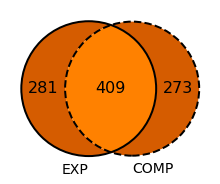

In [92]:
venn_data(class_labels_residues_exp,class_labels_residues,1,'#d55c00')
plt.savefig('./Figures/PTEN_venn_red_variants.pdf', bbox_inches='tight')

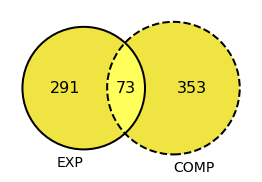

In [93]:
venn_data(class_labels_residues_exp,class_labels_residues,2,'#f0e442')
plt.savefig('./Figures/PTEN_venn_yellow_variants.pdf', bbox_inches='tight')

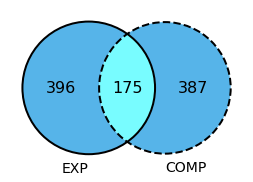

In [94]:
venn_data(class_labels_residues_exp,class_labels_residues,3,'#56b4e9')
plt.savefig('./Figures/PTEN_venn_blue_variants.pdf', bbox_inches='tight')

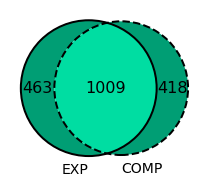

In [95]:
venn_data(class_labels_residues_exp,class_labels_residues,4,'#009e74')
plt.savefig('./Figures/PTEN_venn_green_variants.pdf', bbox_inches='tight')

## Statistics on matched residues

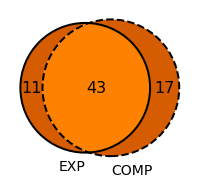

In [96]:
venn_data_mode(y2_exp,mode_value_class,1,'#d55c00')
plt.savefig('./Figures/PTEN_venn_red.pdf', bbox_inches='tight')

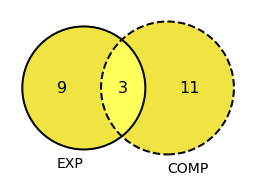

In [97]:
venn_data_mode(y2_exp,mode_value_class,2,'#f0e442')
plt.savefig('./Figures/PTEN_venn_yellow.pdf', bbox_inches='tight')

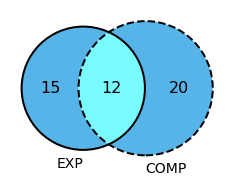

In [98]:
venn_data_mode(y2_exp,mode_value_class,3,'#56b4e9')
plt.savefig('./Figures/PTEN_venn_blue.pdf', bbox_inches='tight')

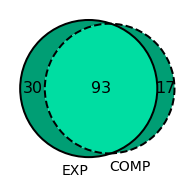

In [99]:
venn_data_mode(y2_exp,mode_value_class,4,'#009e74')
plt.savefig('./Figures/PTEN_venn_green.pdf', bbox_inches='tight')

## MAVE Position cluster analysis

### 4 clusters

- normalized activity score for clustering

In [100]:
activity_PTEN_scores_norm=np.copy(activity_PTEN_scores)
c_min_act=np.percentile(activity_PTEN_scores[~np.isnan(activity_PTEN_scores)],5)
c_max_act=np.percentile(activity_PTEN_scores[~np.isnan(activity_PTEN_scores)],95)
for i in range(activity_PTEN_scores.shape[0]):
    for j in range(activity_PTEN_scores.shape[1]):
        activity_PTEN_scores_norm[i,j]=(activity_PTEN_scores[i,j]-c_min_act)/(c_max_act-c_min_act)

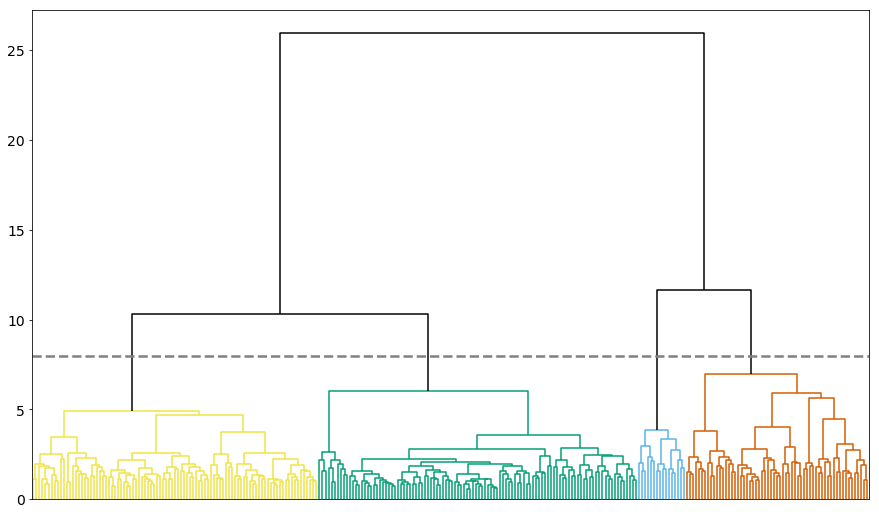

In [101]:
residues_distances=[]
mapping_pos=[]
for r in range(0,len(PTEN_WT_sequence)):
    temp=[]
    if np.isnan(y2_exp[r]) != True:
        for j in range(20):
                if np.isnan(activity_PTEN_scores_norm[r,j])!=True  and alphabetAA_D_L[j+1] != PTEN_WT_sequence[r]:
                    temp.append(activity_PTEN_scores_norm[r,j])
                elif np.isnan(activity_PTEN_scores_norm[r,j])==True and alphabetAA_D_L[j+1] != PTEN_WT_sequence[r]:
                    temp.append(np.mean(activity_PTEN_scores_norm[r,:][~np.isnan(activity_PTEN_scores_norm[r,:])]))
                elif alphabetAA_D_L[j+1] == PTEN_WT_sequence[r]:
                    temp.append(1.0)
    
        for j in range(20):
                if np.isnan(abundance_PTEN_scores[r,j])!=True  and alphabetAA_D_L[j+1] != PTEN_WT_sequence[r]:
                    temp.append(abundance_PTEN_scores[r,j])
                elif np.isnan(abundance_PTEN_scores[r,j])==True and alphabetAA_D_L[j+1] != PTEN_WT_sequence[r]:
                    temp.append(np.mean(abundance_PTEN_scores[r,:][~np.isnan(abundance_PTEN_scores[r,:])]))
                elif alphabetAA_D_L[j+1] == PTEN_WT_sequence[r]:
                    temp.append(1.0)

        residues_distances.append(temp)
        mapping_pos.append(r)
    
Z = linkage(residues_distances, 'ward',metric='euclidean')

fig = plt.figure(figsize=(15,9))

sp.cluster.hierarchy.set_link_color_palette(["#f0e442","#009e74","#56b4e9","#d55c00"])
dn = dendrogram(Z,color_threshold=8,above_threshold_color='k',no_labels=True)
plt.axhline(y=8, c='grey', lw=2.5, linestyle='dashed')
plt.savefig('./Figures/PTEN_cluster_tree_4clusters.pdf')

278


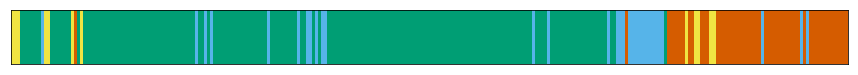

In [102]:
res_list=[]
print(len(mapping_pos))
for i in dn['ivl']:
    res_list.append(y2_exp[mapping_pos[int(i)]])
fig, ax = plt.subplots(figsize=(15,1))
ax.imshow(np.transpose(res_list), aspect = 'auto',
           cmap=mpl.colors.ListedColormap(["#d55c00" , "#f0e442","#56b4e9", "#009e74"]))
ax.set_yticks([],[])
ax.set_xticks([],[])
plt.savefig('./Figures/PTEN_cluster_color_comparison_4clusters.pdf')

In [103]:
k=4
clusters_4=[fcluster(Z, k, criterion='maxclust')]
dict_clusters={1:2,2:4,3:3,4:1}

rearange_clusters_mode=np.copy(mode_value_class_PTEN_exp)
rearange_clusters_mode[:]=np.nan

for i in range(len(mapping_pos)):
        rearange_clusters_mode[mapping_pos[i]]=dict_clusters[clusters_4[0][i]]



In [104]:
labels=['COLOR','CLUSTER']

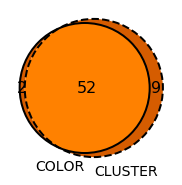

In [105]:
venn_data_mode(y2_exp,rearange_clusters_mode,1,'#d55c00',labels=labels)
plt.savefig('./Figures/PTEN_4clusters_venn_red.pdf', bbox_inches='tight')

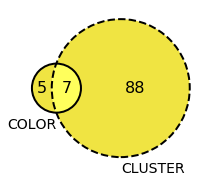

In [106]:
venn_data_mode(y2_exp,rearange_clusters_mode,2,'#f0e442',labels=labels)
plt.savefig('./Figures/PTEN_4clusters_yellow.pdf', bbox_inches='tight')

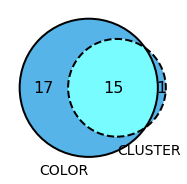

In [107]:
venn_data_mode(y2_exp,rearange_clusters_mode,3,'#56b4e9',labels=labels)
plt.savefig('./Figures/PTEN_4clusters_blue.pdf', bbox_inches='tight')

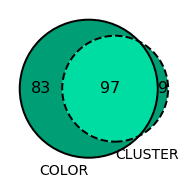

In [108]:
venn_data_mode(y2_exp,rearange_clusters_mode,4,'#009e74',labels=labels)
plt.savefig('./Figures/PTEN_4clusters_green.pdf', bbox_inches='tight')

### 3 clusters

- normalized activity score for clustering

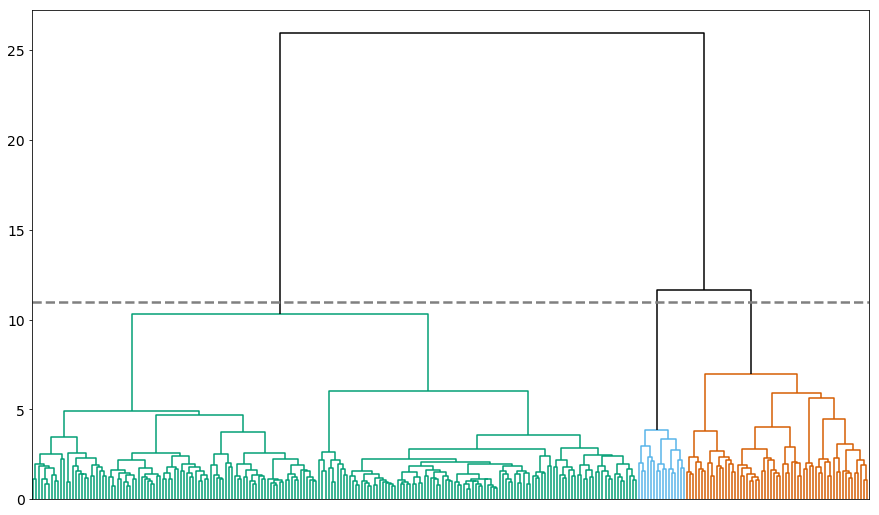

In [109]:
residues_distances=[]
mapping_pos=[]
for r in range(0,len(PTEN_WT_sequence)):
    temp=[]
    if np.isnan(y2_exp[r]) != True:
        for j in range(20):
                if np.isnan(activity_PTEN_scores_norm[r,j])!=True  and alphabetAA_D_L[j+1] != PTEN_WT_sequence[r]:
                    temp.append(activity_PTEN_scores_norm[r,j])
                elif np.isnan(activity_PTEN_scores_norm[r,j])==True and alphabetAA_D_L[j+1] != PTEN_WT_sequence[r]:
                    temp.append(np.mean(activity_PTEN_scores_norm[r,:][~np.isnan(activity_PTEN_scores_norm[r,:])]))
                elif alphabetAA_D_L[j+1] == PTEN_WT_sequence[r]:
                    temp.append(1.0)
    
        for j in range(20):
                if np.isnan(abundance_PTEN_scores[r,j])!=True  and alphabetAA_D_L[j+1] != PTEN_WT_sequence[r]:
                    temp.append(abundance_PTEN_scores[r,j])
                elif np.isnan(abundance_PTEN_scores[r,j])==True and alphabetAA_D_L[j+1] != PTEN_WT_sequence[r]:
                    temp.append(np.mean(abundance_PTEN_scores[r,:][~np.isnan(abundance_PTEN_scores[r,:])]))
                elif alphabetAA_D_L[j+1] == PTEN_WT_sequence[r]:
                    temp.append(1.0)

        residues_distances.append(temp)
        mapping_pos.append(r)
    
Z = linkage(residues_distances, 'ward',metric='euclidean')

fig = plt.figure(figsize=(15,9))

sp.cluster.hierarchy.set_link_color_palette(["#009e74","#56b4e9","#d55c00"])
dn = dendrogram(Z,color_threshold=11,above_threshold_color='k',no_labels=True)
plt.axhline(y=11, c='grey', lw=2.5, linestyle='dashed')
plt.savefig('./Figures/PTEN_cluster_tree_3clusters.pdf')

278


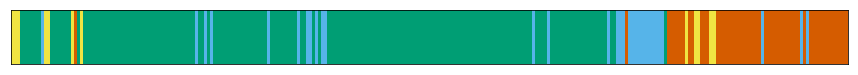

In [110]:
res_list=[]
print(len(mapping_pos))
for i in dn['ivl']:
    res_list.append(y2_exp[mapping_pos[int(i)]])
fig, ax = plt.subplots(figsize=(15,1))
ax.imshow(np.transpose(res_list), aspect = 'auto',
           cmap=mpl.colors.ListedColormap(["#d55c00" , "#f0e442","#56b4e9", "#009e74"]))
ax.set_yticks([],[])
ax.set_xticks([],[])
plt.savefig('./Figures/PTEN_cluster_color_comparison_3clusters.pdf')

In [111]:
k=4
clusters_4=[fcluster(Z, k, criterion='maxclust')]
dict_clusters={1:4,2:4,3:3,4:1}

rearange_clusters_mode=np.copy(mode_value_class_PTEN_exp)
rearange_clusters_mode[:]=np.nan

for i in range(len(mapping_pos)):
        rearange_clusters_mode[mapping_pos[i]]=dict_clusters[clusters_4[0][i]]



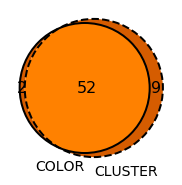

In [112]:
venn_data_mode(y2_exp,rearange_clusters_mode,1,'#d55c00',labels=labels)
plt.savefig('./Figures/PTEN_3clusters_venn_red.pdf', bbox_inches='tight')

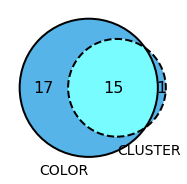

In [113]:
venn_data_mode(y2_exp,rearange_clusters_mode,3,'#56b4e9',labels=labels)
plt.savefig('./Figures/PTEN_3clusters_blue.pdf', bbox_inches='tight')

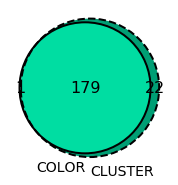

In [114]:
venn_data_mode(y2_exp,rearange_clusters_mode,4,'#009e74',labels=labels)
plt.savefig('./Figures/PTEN_3clusters_green.pdf', bbox_inches='tight')

## Computational position cluster analysis

In [115]:
normalized_coevo_scores=np.copy(coevo_PTEN_scores)
c_min_act=np.percentile(coevo_PTEN_scores[~np.isnan(coevo_PTEN_scores)],5)
c_max_act=np.percentile(coevo_PTEN_scores[~np.isnan(coevo_PTEN_scores)],95)
for i in range(coevo_PTEN_scores.shape[0]):
    for j in range(coevo_PTEN_scores.shape[1]):
        normalized_coevo_scores[i,j]=(coevo_PTEN_scores[i,j]-c_min_act)/(c_max_act-c_min_act)

In [116]:
normalized_rosetta_scores=np.copy(rosetta_PTEN_ddg)
r_min_act=np.percentile(rosetta_PTEN_ddg[~np.isnan(rosetta_PTEN_ddg)],5)
r_max_act=np.percentile(rosetta_PTEN_ddg[~np.isnan(rosetta_PTEN_ddg)],95)
for i in range(rosetta_PTEN_ddg.shape[0]):
    for j in range(rosetta_PTEN_ddg.shape[1]):
        normalized_rosetta_scores[i,j]=(rosetta_PTEN_ddg[i,j]-r_min_act)/(r_max_act-r_min_act)

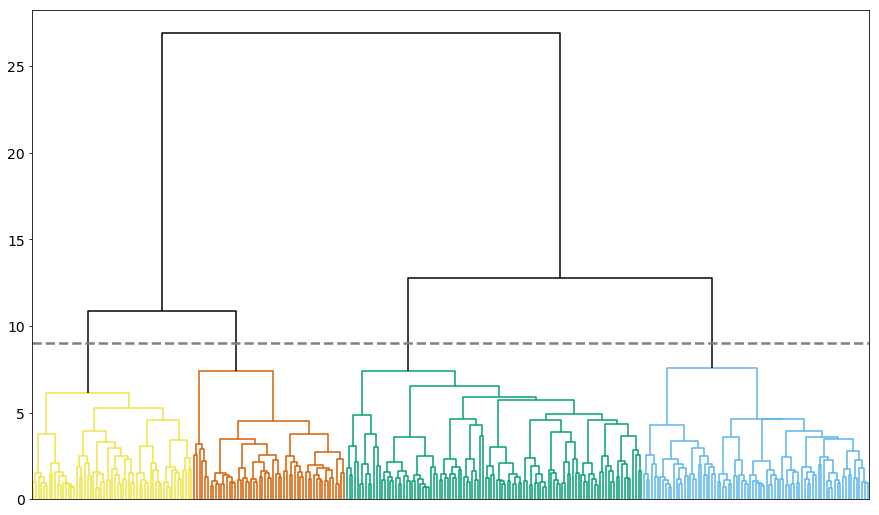

In [117]:
residues_distances=[]
mapping_pos=[]
for r in range(0,len(PTEN_WT_sequence)):
    temp=[]
    if np.isnan(mode_value_class[r]) != True:
        for j in range(20):
                if np.isnan(normalized_coevo_scores[r,j])!=True  and alphabetAA_D_L[j+1] != PTEN_WT_sequence[r]:
                    temp.append(normalized_coevo_scores[r,j])
                elif np.isnan(normalized_coevo_scores[r,j])==True and alphabetAA_D_L[j+1] != PTEN_WT_sequence[r]:
                    temp.append(np.mean(normalized_coevo_scores[r,:][~np.isnan(normalized_coevo_scores[r,:])]))
                elif alphabetAA_D_L[j+1] == PTEN_WT_sequence[r]:
                    temp.append(1.0)
    
        for j in range(20):
                if np.isnan(normalized_rosetta_scores[r,j])!=True  and alphabetAA_D_L[j+1] != PTEN_WT_sequence[r]:
                    temp.append(normalized_rosetta_scores[r,j])
                elif np.isnan(normalized_rosetta_scores[r,j])==True and alphabetAA_D_L[j+1] != PTEN_WT_sequence[r]:
                    temp.append(np.mean(normalized_rosetta_scores[r,:][~np.isnan(abundance_PTEN_scores[r,:])]))
                elif alphabetAA_D_L[j+1] == PTEN_WT_sequence[r]:
                    temp.append(1.0)

        residues_distances.append(temp)
        mapping_pos.append(r)
    
Z = linkage(residues_distances, 'ward',metric='euclidean')

fig = plt.figure(figsize=(15,9))

sp.cluster.hierarchy.set_link_color_palette(["#f0e442","#d55c00","#009e74","#56b4e9"])
dn = dendrogram(Z,color_threshold=9,above_threshold_color='k',no_labels=True)
plt.axhline(y=9, c='grey', lw=2.5, linestyle='dashed')
plt.savefig('./Figures/PTEN_comp_cluster_tree.pdf')

- agreement with computational threshold classification

307


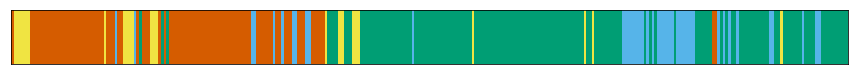

In [118]:
res_list=[]
print(len(mapping_pos))
for i in dn['ivl']:
    res_list.append(mode_value_class[mapping_pos[int(i)]])
fig, ax = plt.subplots(figsize=(15,1))
ax.imshow(np.transpose(res_list), aspect = 'auto',
           cmap=mpl.colors.ListedColormap(["#d55c00" , "#f0e442","#56b4e9", "#009e74"]))
ax.set_yticks([],[])
ax.set_xticks([],[])
plt.savefig('./Figures/PTEN_comp_exp_cluster_color_comparison.pdf')

- agreement with MAVE threshold classification

307


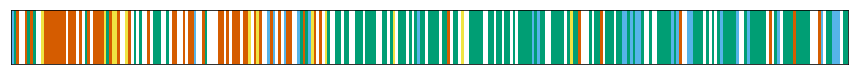

In [119]:
res_list=[]
print(len(mapping_pos))
for i in dn['ivl']:
    res_list.append(y2_exp[mapping_pos[int(i)]])
fig, ax = plt.subplots(figsize=(15,1))
ax.imshow(np.transpose(res_list), aspect = 'auto',
           cmap=mpl.colors.ListedColormap(["#d55c00" , "#f0e442","#56b4e9", "#009e74"]))
ax.set_yticks([],[])
ax.set_xticks([],[])
plt.savefig('./Figures/PTEN_comp_comp_cluster_color_comparison.pdf')